# Resampling and Modelling using Logistic Regression

# Introduction

Here I will create feature variables for use with the logistic regression model to create a baseline performance for predicting CTR on Google AdWords data.

First the data will need to be either weighted or resampled to remove class imbalance. The class imbalance is not too severe from first impressions.

Then the mdoels will be evaluated and tuned to get the best performance for the various machin learning models so that thety can then be used as measures against more deep learning methods that perhaps will be able to capture any non-linear coefficients that the data may exhibit. 

Various evaluation techniques will be used based around the principles of recall, precision and accuracy


# Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.metrics import make_scorer, matthews_corrcoef, brier_score_loss, log_loss, roc_auc_score, roc_curve
import scikitplot as skplt
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.metrics import *
from xgboost import XGBClassifier
from category_encoders.ordinal import OrdinalEncoder
%matplotlib inline

In [2]:
import pandas as pd
train_data = pd.read_csv('../data/interim/train_data.csv', 
                        parse_dates=['Date'])

# train_data = pd.read_csv('../data/interim/train_data_with_text.csv', 
#                         parse_dates=['Date'])

In [3]:
train_data.head()

,Unnamed: 0,Ad ID,Search term match type,Date,Device,Quality score,Expected clickthrough rate,Ad relevance,Keyword max CPC,First position CPC,...,Campaign,Ad group,Avg. position,Impressions,Clicks,Cost,click_target,ctr,Month,Day of Month
0,3,357859795387,Phrase,2019-08-11,Mobile,9,Above average,Average,0.68,0.81,...,Think-Employees,Generic_Cycle,1.12,16,8,0.9,1,0.5,8,11
1,8,357859795387,Phrase,2019-08-04,Desktop,9,Above average,Average,0.68,0.81,...,Think-Employees,Generic_Cycle,1.75,4,0,0.0,0,0.0,8,4
2,9,314179203833,Broad,2019-08-08,Desktop,8,Above average,Below average,0.51,0.54,...,Think-Employers,Guidance/Help,1.00,1,0,0.0,0,0.0,8,8
3,10,357859796842,Exact,2019-08-09,Desktop,9,Above average,Average,0.55,4.94,...,Do-Competitors,Bike2work,2.00,2,0,0.0,0,0.0,8,9
4,11,357859795387,Phrase,2019-08-20,Tablet,9,Above average,Average,0.68,0.81,...,Think-Employees,Generic_Cycle,3.00,1,0,0.0,0,0.0,8,20


In [4]:
train_data.columns

Index(['Unnamed: 0', 'Ad ID', 'Search term match type', 'Date', 'Device',
       'Quality score', 'Expected clickthrough rate', 'Ad relevance',
       'Keyword max CPC', 'First position CPC', 'Top of page CPC',
       'Landing page experience', 'Campaign', 'Ad group', 'Avg. position',
       'Impressions', 'Clicks', 'Cost', 'click_target', 'ctr', 'Month',
       'Day of Month'],
      dtype='object')

In [5]:
train_data.shape

(115169, 22)

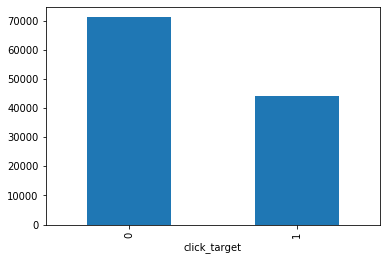

In [6]:
# a quick glance at class balance
train_data.groupby('click_target').size().plot(kind = 'bar')

As mentioned in the introduction, there is class imbalance this will need to tbe fixed before modelling. The class imbalance however is not too severe, so class weight methods could be used in place of resampling.

# Pre-Processing

In [7]:
# check for any NaN
print(train_data.isna().values.sum())

0


In [8]:
train_data.columns[train_data.isna().any()].tolist()

[]

## Create new features from time

In [9]:
train_data['Day of Year'] = train_data['Date'].dt.dayofyear
train_data['Week of Year'] = train_data['Date'].dt.week
train_data['Day of Week'] = train_data['Date'].dt.dayofweek

## Replace '--' in AdWords Data

In [10]:
# replace '--' with NaN
train_data = train_data.replace({'--': np.nan}, regex=True)

In [11]:
# remove all entries with NaN
train_data = train_data.dropna()

In [12]:
# check for any NaN
print(train_data.isna().values.sum())

0


In [13]:
# take one value for sense checking
train_data.head()

,Unnamed: 0,Ad ID,Search term match type,Date,Device,Quality score,Expected clickthrough rate,Ad relevance,Keyword max CPC,First position CPC,...,Impressions,Clicks,Cost,click_target,ctr,Month,Day of Month,Day of Year,Week of Year,Day of Week
0,3,357859795387,Phrase,2019-08-11,Mobile,9,Above average,Average,0.68,0.81,...,16,8,0.9,1,0.5,8,11,223,32,6
1,8,357859795387,Phrase,2019-08-04,Desktop,9,Above average,Average,0.68,0.81,...,4,0,0.0,0,0.0,8,4,216,31,6
2,9,314179203833,Broad,2019-08-08,Desktop,8,Above average,Below average,0.51,0.54,...,1,0,0.0,0,0.0,8,8,220,32,3
3,10,357859796842,Exact,2019-08-09,Desktop,9,Above average,Average,0.55,4.94,...,2,0,0.0,0,0.0,8,9,221,32,4
4,11,357859795387,Phrase,2019-08-20,Tablet,9,Above average,Average,0.68,0.81,...,1,0,0.0,0,0.0,8,20,232,34,1


## Create Category Data from Object Data

In [14]:
train_data['Quality score'] = train_data['Quality score'].astype(str)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115169 entries, 0 to 115168
Data columns (total 25 columns):
Unnamed: 0                    115169 non-null int64
Ad ID                         115169 non-null int64
Search term match type        115169 non-null object
Date                          115169 non-null datetime64[ns]
Device                        115169 non-null object
Quality score                 115169 non-null object
Expected clickthrough rate    115169 non-null object
Ad relevance                  115169 non-null object
Keyword max CPC               115169 non-null float64
First position CPC            115169 non-null float64
Top of page CPC               115169 non-null float64
Landing page experience       115169 non-null object
Campaign                      115169 non-null object
Ad group                      115169 non-null object
Avg. position                 115169 non-null float64
Impressions                   115169 non-null int64
Clicks                        11

In [16]:
# create category df
cat_df = train_data.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

In [17]:
# remove object columns
train_data_obj = train_data.select_dtypes(exclude=['object'])

In [18]:
# concat new cat columns
train_data = pd.concat([train_data_obj, cat_df], axis=1)

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115169 entries, 0 to 115168
Data columns (total 25 columns):
Unnamed: 0                    115169 non-null int64
Ad ID                         115169 non-null int64
Date                          115169 non-null datetime64[ns]
Keyword max CPC               115169 non-null float64
First position CPC            115169 non-null float64
Top of page CPC               115169 non-null float64
Avg. position                 115169 non-null float64
Impressions                   115169 non-null int64
Clicks                        115169 non-null int64
Cost                          115169 non-null float64
click_target                  115169 non-null int64
ctr                           115169 non-null float64
Month                         115169 non-null int64
Day of Month                  115169 non-null int64
Day of Year                   115169 non-null int64
Week of Year                  115169 non-null int64
Day of Week                   115169

In [20]:
train_data.shape

(115169, 25)

In [21]:
train_data.reset_index(inplace=True)

In [22]:
train_data.drop(columns=['index'], inplace=True)

In [23]:
train_data.head()

,Unnamed: 0,Ad ID,Date,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,Cost,...,Week of Year,Day of Week,Search term match type,Device,Quality score,Expected clickthrough rate,Ad relevance,Landing page experience,Campaign,Ad group
0,3,357859795387,2019-08-11,0.68,0.81,0.68,1.12,16,8,0.9,...,32,6,Phrase,Mobile,9,Above average,Average,Above average,Think-Employees,Generic_Cycle
1,8,357859795387,2019-08-04,0.68,0.81,0.68,1.75,4,0,0.0,...,31,6,Phrase,Desktop,9,Above average,Average,Above average,Think-Employees,Generic_Cycle
2,9,314179203833,2019-08-08,0.51,0.54,0.21,1.00,1,0,0.0,...,32,3,Broad,Desktop,8,Above average,Below average,Above average,Think-Employers,Guidance/Help
3,10,357859796842,2019-08-09,0.55,4.94,0.35,2.00,2,0,0.0,...,32,4,Exact,Desktop,9,Above average,Average,Above average,Do-Competitors,Bike2work
4,11,357859795387,2019-08-20,0.68,0.81,0.68,3.00,1,0,0.0,...,34,1,Phrase,Tablet,9,Above average,Average,Above average,Think-Employees,Generic_Cycle


# Feature Engineering

In [24]:
# select these cat columns for later
categorical_columns = list(train_data.select_dtypes(['category']).columns)

In [25]:
categorical_columns

['Search term match type',
 'Device',
 'Quality score',
 'Expected clickthrough rate',
 'Ad relevance',
 'Landing page experience',
 'Campaign',
 'Ad group']

In [26]:
categorical_columns = categorical_columns[0:6]

In [27]:
categorical_columns

['Search term match type',
 'Device',
 'Quality score',
 'Expected clickthrough rate',
 'Ad relevance',
 'Landing page experience']

## Ordinal Data Encoding

`Quality score`, `Expected clickthrough rate`, `Ad relevance` and `Landing page experience` are all categorical variables that should be encoded as ordered data. The values have inherent information in relation to each other

In [28]:
ordinal_categorical_columns = categorical_columns[2:]

In [29]:
one_hot_categorical_columns = list(categorical_columns[i] for i in [0, 1] )

In [30]:
ordinal_categorical_columns

['Quality score',
 'Expected clickthrough rate',
 'Ad relevance',
 'Landing page experience']

In [31]:
ordinal_col_mapping = [{
    "col": "Quality score",
    "mapping": {
        '10': 6,
        '9': 5,
        '8': 4,
        '7': 3,
        '6': 2,
        '5': 1,
        '4': 0
    }}, {
    "col": "Expected clickthrough rate",
    "mapping": {
        'Above average': 1,
        'Average': 0
    }},
    {
    "col": "Ad relevance",
    "mapping": {
        'Above average': 2,
        'Average': 1,
        'Below average': 0
    }},
    {
    "col": "Landing page experience",
    "mapping": {
        'Above average': 2,
        'Average': 1,
        'Below average': 0
    }}
] 

In [32]:
# create encoder instance
ord_enc = OrdinalEncoder(mapping=ordinal_col_mapping, return_df=True)
ord_enc

OrdinalEncoder(cols=None, drop_invariant=False, handle_missing='value',
               handle_unknown='value',
               mapping=[{'col': 'Quality score',
                         'mapping': {'10': 6, '4': 0, '5': 1, '6': 2, '7': 3,
                                     '8': 4, '9': 5}},
                        {'col': 'Expected clickthrough rate',
                         'mapping': {'Above average': 1, 'Average': 0}},
                        {'col': 'Ad relevance',
                         'mapping': {'Above average': 2, 'Average': 1,
                                     'Below average': 0}},
                        {'col': 'Landing page experience',
                         'mapping': {'Above average': 2, 'Average': 1,
                                     'Below average': 0}}],
               return_df=True, verbose=0)

## Create New Transformed DF - Train with Orindal Encoding

In [33]:
# fit ordinal encoding and tranform
df_train = ord_enc.fit_transform(train_data)
df_train.head()

,Unnamed: 0,Ad ID,Date,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,Cost,...,Week of Year,Day of Week,Search term match type,Device,Quality score,Expected clickthrough rate,Ad relevance,Landing page experience,Campaign,Ad group
0,3,357859795387,2019-08-11,0.68,0.81,0.68,1.12,16,8,0.9,...,32,6,Phrase,Mobile,5,1,1,2,Think-Employees,Generic_Cycle
1,8,357859795387,2019-08-04,0.68,0.81,0.68,1.75,4,0,0.0,...,31,6,Phrase,Desktop,5,1,1,2,Think-Employees,Generic_Cycle
2,9,314179203833,2019-08-08,0.51,0.54,0.21,1.00,1,0,0.0,...,32,3,Broad,Desktop,4,1,0,2,Think-Employers,Guidance/Help
3,10,357859796842,2019-08-09,0.55,4.94,0.35,2.00,2,0,0.0,...,32,4,Exact,Desktop,5,1,1,2,Do-Competitors,Bike2work
4,11,357859795387,2019-08-20,0.68,0.81,0.68,3.00,1,0,0.0,...,34,1,Phrase,Tablet,5,1,1,2,Think-Employees,Generic_Cycle


In [34]:
df_train.columns

Index(['Unnamed: 0', 'Ad ID', 'Date', 'Keyword max CPC', 'First position CPC',
       'Top of page CPC', 'Avg. position', 'Impressions', 'Clicks', 'Cost',
       'click_target', 'ctr', 'Month', 'Day of Month', 'Day of Year',
       'Week of Year', 'Day of Week', 'Search term match type', 'Device',
       'Quality score', 'Expected clickthrough rate', 'Ad relevance',
       'Landing page experience', 'Campaign', 'Ad group'],
      dtype='object')

In [35]:
df_train.shape

(115169, 25)

## One-Hot Encoding

In [36]:
# get dummies encoding                                                                      
df_train = pd.concat([df_train, pd.get_dummies(df_train[one_hot_categorical_columns])], axis=1)

In [37]:
# drop transformed columns
df_train.drop(columns=one_hot_categorical_columns, inplace=True)

In [38]:
df_train.columns

Index(['Unnamed: 0', 'Ad ID', 'Date', 'Keyword max CPC', 'First position CPC',
       'Top of page CPC', 'Avg. position', 'Impressions', 'Clicks', 'Cost',
       'click_target', 'ctr', 'Month', 'Day of Month', 'Day of Year',
       'Week of Year', 'Day of Week', 'Quality score',
       'Expected clickthrough rate', 'Ad relevance', 'Landing page experience',
       'Campaign', 'Ad group', 'Search term match type_Broad',
       'Search term match type_Exact', 'Search term match type_Phrase',
       'Device_Desktop', 'Device_Mobile', 'Device_Tablet'],
      dtype='object')

In [39]:
df_train.shape

(115169, 29)

## Cyclical Encoding of Time

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:

$x_{sin} = \sin(\frac{2 * \pi * x}{\max(x)})$

$x_{cos} = \cos(\frac{2 * \pi * x}{\max(x)})$

Let's do this for the time components that are cyclical

In [ ]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [41]:
# check dtypes before continuing
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115169 entries, 0 to 115168
Data columns (total 29 columns):
Unnamed: 0                       115169 non-null int64
Ad ID                            115169 non-null int64
Date                             115169 non-null datetime64[ns]
Keyword max CPC                  115169 non-null float64
First position CPC               115169 non-null float64
Top of page CPC                  115169 non-null float64
Avg. position                    115169 non-null float64
Impressions                      115169 non-null int64
Clicks                           115169 non-null int64
Cost                             115169 non-null float64
click_target                     115169 non-null int64
ctr                              115169 non-null float64
Month                            115169 non-null int64
Day of Month                     115169 non-null int64
Day of Year                      115169 non-null int64
Week of Year                     115169 non

In [42]:
# encoding cyclical features
df_train['day_of_week_sin'] = np.sin(df_train['Day of Week'])*(2.*np.pi/7)
df_train['day_of_week_cos'] = np.cos(df_train['Day of Week'])*(2.*np.pi/7)
df_train['month_sin'] = np.sin((df_train['Month']-1)*(2.*np.pi/12))
df_train['month_cos'] = np.cos((df_train['Month']-1)*(2.*np.pi/12))
df_train['day_of_year_sin'] = np.sin((df_train['Day of Year']-1)*(2.*np.pi/365))
df_train['day_of_year_cos'] = np.cos((df_train['Day of Year']-1)*(2.*np.pi/365))
# date or day of month is a potential to investigate later ie. 31, 26 etc

In [43]:
# after this we can drop the Date column as it will not be used
df_train.drop(columns='Date', inplace=True)

In [44]:
# preview data once more
df_train.head()

,Unnamed: 0,Ad ID,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,Cost,click_target,...,Search term match type_Phrase,Device_Desktop,Device_Mobile,Device_Tablet,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,3,357859795387,0.68,0.81,0.68,1.12,16,8,0.9,1,...,1,0,1,0,-0.250803,0.861847,-0.5,-0.866025,-0.628763,-0.777597
1,8,357859795387,0.68,0.81,0.68,1.75,4,0,0.0,0,...,1,1,0,0,-0.250803,0.861847,-0.5,-0.866025,-0.530730,-0.847541
2,9,314179203833,0.51,0.54,0.21,1.00,1,0,0.0,0,...,0,1,0,0,0.126669,-0.888615,-0.5,-0.866025,-0.587785,-0.809017
3,10,357859796842,0.55,4.94,0.35,2.00,2,0,0.0,0,...,0,1,0,0,-0.679304,-0.586709,-0.5,-0.866025,-0.601624,-0.798779
4,11,357859795387,0.68,0.81,0.68,3.00,1,0,0.0,0,...,1,0,0,1,0.755303,0.484974,-0.5,-0.866025,-0.741222,-0.671260


In [45]:
df_train.shape

(115169, 34)

## Removing Irrelevant Variables - Text Based

Future work will use the textual based columns to retrieve word embeddings and use Word2Vec algorithms to enable them as features

In [46]:
df_train.columns

Index(['Unnamed: 0', 'Ad ID', 'Keyword max CPC', 'First position CPC',
       'Top of page CPC', 'Avg. position', 'Impressions', 'Clicks', 'Cost',
       'click_target', 'ctr', 'Month', 'Day of Month', 'Day of Year',
       'Week of Year', 'Day of Week', 'Quality score',
       'Expected clickthrough rate', 'Ad relevance', 'Landing page experience',
       'Campaign', 'Ad group', 'Search term match type_Broad',
       'Search term match type_Exact', 'Search term match type_Phrase',
       'Device_Desktop', 'Device_Mobile', 'Device_Tablet', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin',
       'day_of_year_cos'],
      dtype='object')

In [50]:
df_train.drop(columns=['Ad group', 'Campaign'], inplace=True)

KeyError: "['Ad group' 'Campaign'] not found in axis"

In [51]:
df_train.drop(columns=['Ad ID'], inplace=True)

KeyError: "['Ad ID'] not found in axis"

In [52]:
df_train.drop(columns=['Unnamed: 0'], inplace=True)

In [53]:
df_train.drop(columns=['ctr'], inplace=True)

In [54]:
df_train.drop(columns=['Impressions'], inplace=True)

In [55]:
df_train.drop(columns=['Clicks'], inplace=True)

In [56]:
df_train.drop(columns=['Cost'], inplace=True)

In [57]:
df_train.head()

,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,click_target,Month,Day of Month,Day of Year,Week of Year,Day of Week,...,Search term match type_Phrase,Device_Desktop,Device_Mobile,Device_Tablet,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,0.68,0.81,0.68,1.12,1,8,11,223,32,6,...,1,0,1,0,-0.250803,0.861847,-0.5,-0.866025,-0.628763,-0.777597
1,0.68,0.81,0.68,1.75,0,8,4,216,31,6,...,1,1,0,0,-0.250803,0.861847,-0.5,-0.866025,-0.530730,-0.847541
2,0.51,0.54,0.21,1.00,0,8,8,220,32,3,...,0,1,0,0,0.126669,-0.888615,-0.5,-0.866025,-0.587785,-0.809017
3,0.55,4.94,0.35,2.00,0,8,9,221,32,4,...,0,1,0,0,-0.679304,-0.586709,-0.5,-0.866025,-0.601624,-0.798779
4,0.68,0.81,0.68,3.00,0,8,20,232,34,1,...,1,0,0,1,0.755303,0.484974,-0.5,-0.866025,-0.741222,-0.671260


In [58]:
df_train.columns

Index(['Keyword max CPC', 'First position CPC', 'Top of page CPC',
       'Avg. position', 'click_target', 'Month', 'Day of Month', 'Day of Year',
       'Week of Year', 'Day of Week', 'Quality score',
       'Expected clickthrough rate', 'Ad relevance', 'Landing page experience',
       'Search term match type_Broad', 'Search term match type_Exact',
       'Search term match type_Phrase', 'Device_Desktop', 'Device_Mobile',
       'Device_Tablet', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

## Correlation Matrix

In [136]:
cor = df_train.corr(method='pearson')

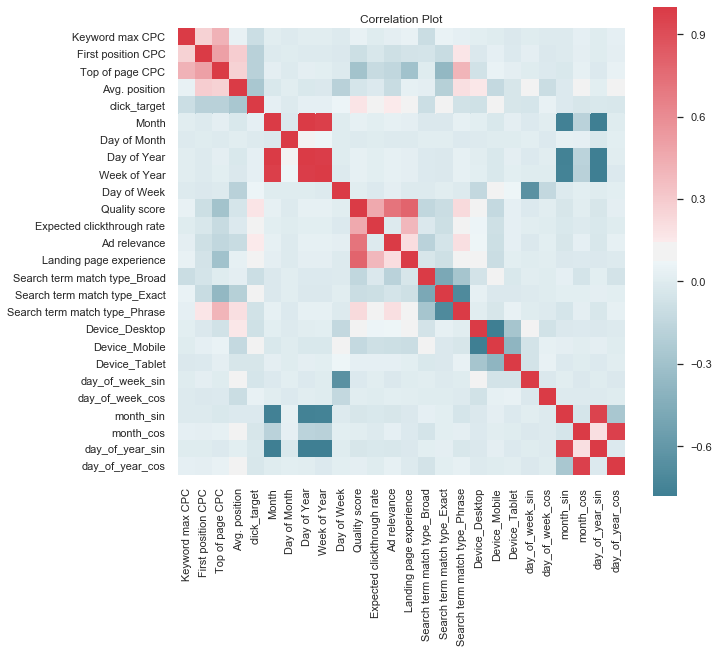

In [140]:
fig, ax = plt.subplots(figsize=(10, 9))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

There seems to be a lot of co-linearity between some variables so removing them will benefit model speed and reduce computation time if they are removed

In [ ]:
df_train.drop(columns=['Ad relevance', 'Expected clickthrough rate', 'Landing page experience'], inplace=True)

# Model Initiation

## Training and Test Data

In [152]:
df_train.columns

Index(['Keyword max CPC', 'First position CPC', 'Top of page CPC',
       'Avg. position', 'click_target', 'Month', 'Day of Month', 'Day of Year',
       'Week of Year', 'Day of Week', 'Quality score',
       'Search term match type_Broad', 'Search term match type_Exact',
       'Search term match type_Phrase', 'Device_Desktop', 'Device_Mobile',
       'Device_Tablet', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

In [153]:
# Separate input features and target
y = df_train.click_target
X = df_train.drop(['click_target'], axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    shuffle=True)

## Rescaling

In [154]:
# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_mm = scaler.fit_transform(X_train)
X_test_mm = scaler.fit_transform(X_test)

In [155]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.fit_transform(X_test)

In [156]:
print("Number records X_train dataset: ", X_train.shape)
print("Number records y_train dataset: ", y_train.shape)
print("Number records X_test dataset: ", X_test.shape)
print("Number records y_test dataset: ", y_test.shape)

Number records X_train dataset:  (86376, 22)
Number records y_train dataset:  (86376,)
Number records X_test dataset:  (28793, 22)
Number records y_test dataset:  (28793,)


In [157]:
print("Number records X_train_mm dataset: ", X_train_mm.shape)
print("Number records X_test_mm dataset: ", X_test_mm.shape)

Number records X_train_mm dataset:  (86376, 22)
Number records X_test_mm dataset:  (28793, 22)


In [158]:
print("Number records X_train dataset: ", X_train_ss.shape)
print("Number records X_test dataset: ", X_test_ss.shape)

Number records X_train dataset:  (86376, 22)
Number records X_test dataset:  (28793, 22)


In [159]:
# Show the class distribution in each label set
def get_class_dist(data, name):
    unique, counts = np.unique(data, return_counts=True)
    pct = 100*(counts/len(data))
    d = dict(zip(unique, zip(counts, pct)))
    print(len(data), 'total examples in %s' % name)
    for key, values in d.items():
        print('class %d: %d examples,' % (key, values[0]), "{0:.2f}%".format(values[1]))
    print('')
    return

get_class_dist(data=y_train, name='y_train')
get_class_dist(data=y_test, name='y_test')

86376 total examples in y_train
class 0: 53396 examples, 61.82%
class 1: 32980 examples, 38.18%

28793 total examples in y_test
class 0: 17718 examples, 61.54%
class 1: 11075 examples, 38.46%



## Correcting Class Imbalance

It is important to perform class balancing on **only the training data**. As shown earlier the entries that are clicked are far less then those that are un-clicked and therefore will not produce a good logistic regression baseline.

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

### Adjusting Class Weights

Before anything is done with resampling methods. Many classification algorithms allow you to assign custom weights to each class to help mitigate imbalance by assigning a higher weight to the minority class. In the case of sklearn’s decision tree classifier, this can be done by setting the `class_weight` option. From the documentation:

>The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`

In [160]:
# Check class weights that a 'balanced' model would use
class_weights = compute_class_weight('balanced', np.unique(y), y)
print(np.unique(y))
print(class_weights)

[0 1]
[0.80974914 1.30710476]


In [161]:
class_weights_dict = {0: class_weights[0],
                1: class_weights[1]}

# Modelling 

## A Quick Model Comaprison

LR: 0.719939 (0.003272)
KNN: 0.655693 (0.004885)
CART: 0.648966 (0.003749)
RF: 0.744051 (0.005279)
NB: 0.711198 (0.003743)


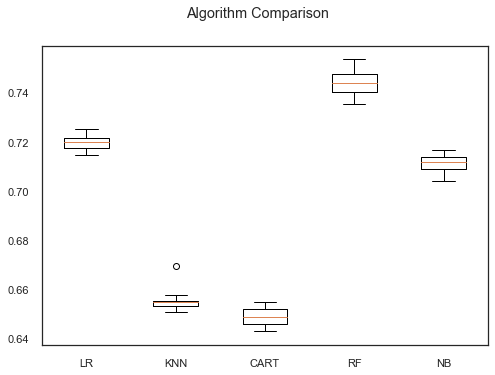

In [162]:
# prepare models
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=3000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Logistic regression and Random forest classifiers look the most promising

Define a plotting fucntion for logistic regression accuracy

In [68]:
def model_plot(X_train, y_train, X_test, y_test, class_weights=None):
    # Define the algorithm we want to use for our model
    clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=3000)

    # Train the model
    clf.fit(X_train, y_train)

    # Create predictions
    y_pred = clf.predict(X_test)
    model_df = pd.DataFrame()
    model_df['y_pred'] = y_pred
    model_df['y_actual'] = y_test
    y_pred_prob = clf.predict_proba(X_test)
    probs = y_pred_prob[:, 1]
    
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)

    # Print results
    print("Predicted customer clicks (test set):", sum(y_pred))
    print("Sum of predicted click probabilities:", "{0:.2f}".format(sum(probs)))
    print("Actual customer clicks (test set):", sum(y_test))
    print('')
    print(metrics.classification_report(y_test, y_pred))

    # Plot results
    skplt.metrics.plot_confusion_matrix(y_test, y_pred)
    skplt.metrics.plot_precision_recall(y_test, y_pred_prob)
    skplt.metrics.plot_roc(y_test, y_pred_prob)
    plt.show()
    return None

Also for Random Forest Classifier

In [98]:
def model_plot_rf(X_train, y_train, X_test, y_test):
    # Define the algorithm we want to use for our model
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

    # Train the model
    clf.fit(X_train, y_train)

    # Create predictions
    y_pred = clf.predict(X_test)
    model_df = pd.DataFrame()
    model_df['y_pred'] = y_pred
    model_df['y_actual'] = y_test
    y_pred_prob = clf.predict_proba(X_test)
    probs = y_pred_prob[:, 1]
    
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)

    # Print results
    print("Predicted customer clicks (test set):", sum(y_pred))
    print("Sum of predicted click probabilities:", "{0:.2f}".format(sum(probs)))
    print("Actual customer clicks (test set):", sum(y_test))
    print('')
    print(metrics.classification_report(y_test, y_pred))

    # Plot results
    skplt.metrics.plot_confusion_matrix(y_test, y_pred)
    skplt.metrics.plot_precision_recall(y_test, y_pred_prob)
    skplt.metrics.plot_roc(y_test, y_pred_prob)
    plt.show()
    return None


## Evaluation Metrics for Binary Classifiers

Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be very misleading. Metrics that can provide better insight include:
1. Confusion Matrix: a table showing correct predictions and types of incorrect predictions.

2. Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
3. Recall: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
4. F1: Score: the weighted average of precision and recall.

## Unmodified Data Modelling

First one should try class weighting to see if resampling ethods are not necessary

`Class weights` have already been established above

### Unscaled

AUC: 0.724
Predicted customer clicks (test set): 8701
Sum of predicted click probabilities: 11048.17
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.71      0.80      0.75     17718
           1       0.60      0.47      0.53     11075

    accuracy                           0.68     28793
   macro avg       0.65      0.64      0.64     28793
weighted avg       0.67      0.68      0.67     28793



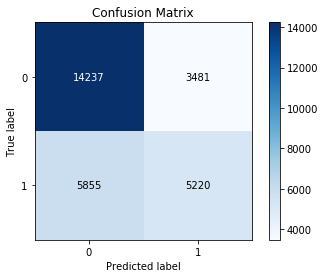

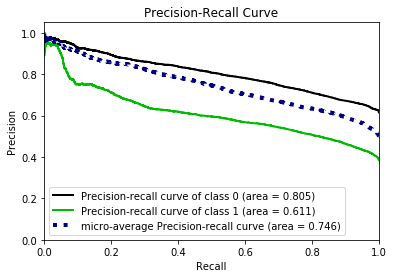

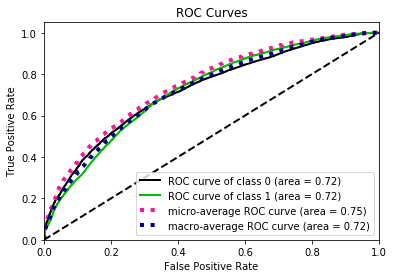

In [69]:
model_plot(X_train, y_train, X_test, y_test)

AUC: 0.744
Predicted customer clicks (test set): 9165
Sum of predicted click probabilities: 11165.89
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.74      0.81      0.77     17718
           1       0.64      0.53      0.58     11075

    accuracy                           0.71     28793
   macro avg       0.69      0.67      0.68     28793
weighted avg       0.70      0.71      0.70     28793



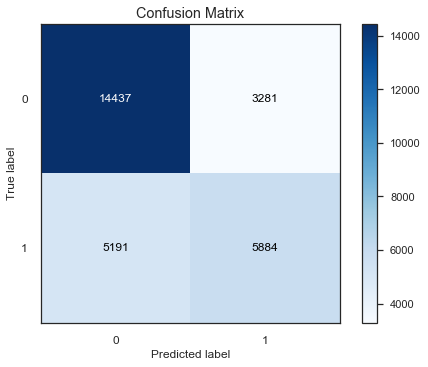

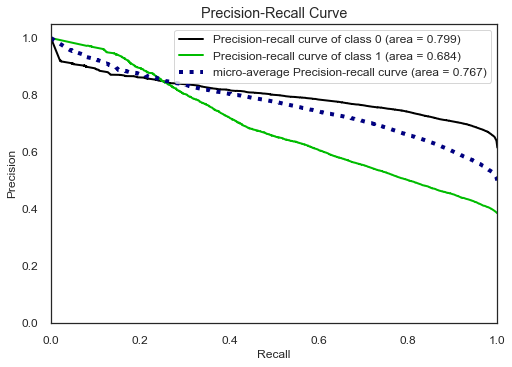

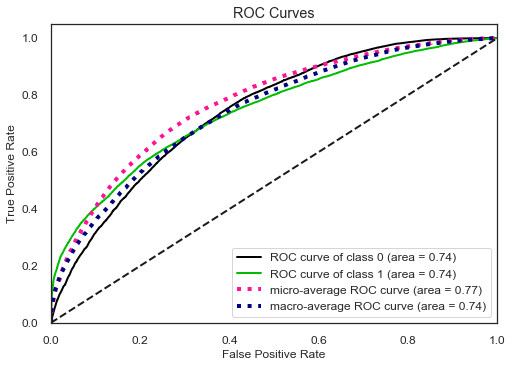

In [111]:
model_plot_rf(X_train, y_train, X_test, y_test)

A slight improvement with RF

### Scaled - MM

AUC: 0.724
Predicted customer clicks (test set): 8665
Sum of predicted click probabilities: 11041.96
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.71      0.80      0.75     17718
           1       0.60      0.47      0.53     11075

    accuracy                           0.68     28793
   macro avg       0.65      0.64      0.64     28793
weighted avg       0.67      0.68      0.67     28793



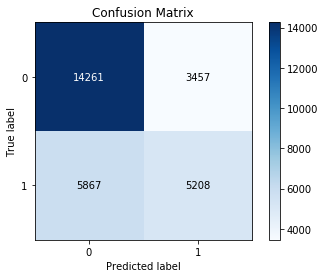

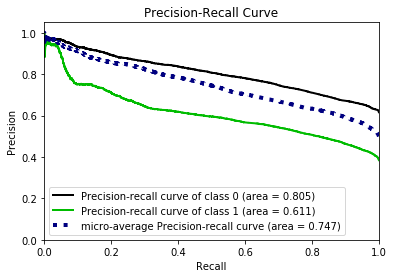

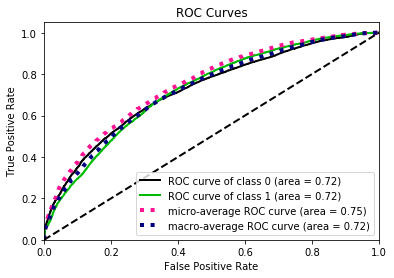

In [70]:
model_plot(X_train_mm, y_train, X_test_mm, y_test)

AUC: 0.744
Predicted customer clicks (test set): 9161
Sum of predicted click probabilities: 11164.71
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.74      0.81      0.77     17718
           1       0.64      0.53      0.58     11075

    accuracy                           0.71     28793
   macro avg       0.69      0.67      0.68     28793
weighted avg       0.70      0.71      0.70     28793



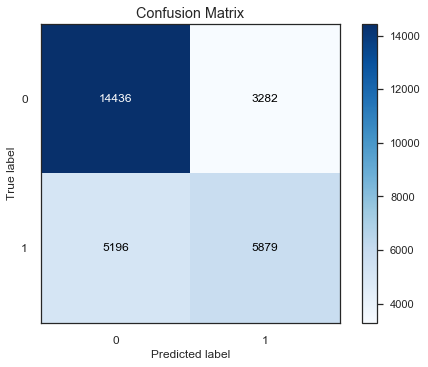

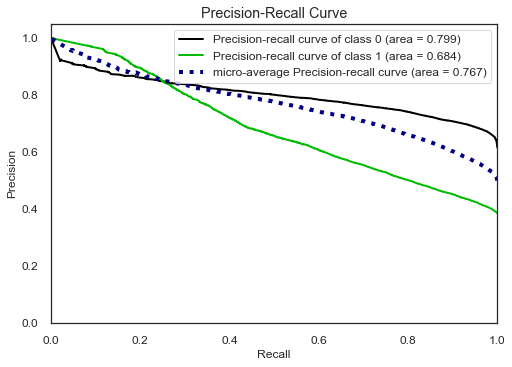

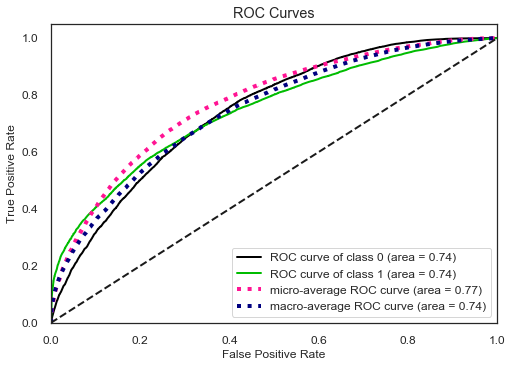

In [112]:
model_plot_rf(X_train_mm, y_train, X_test_mm, y_test)

### Scaled - SS

AUC: 0.724
Predicted customer clicks (test set): 8588
Sum of predicted click probabilities: 10994.62
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.71      0.81      0.75     17718
           1       0.60      0.47      0.53     11075

    accuracy                           0.68     28793
   macro avg       0.66      0.64      0.64     28793
weighted avg       0.67      0.68      0.67     28793



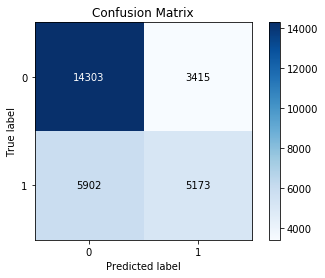

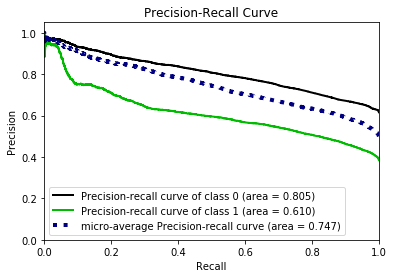

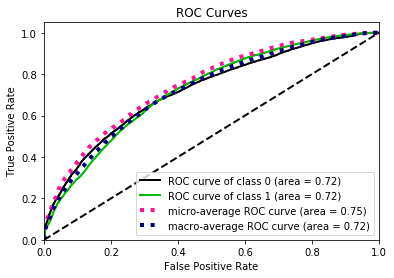

In [71]:
model_plot(X_train_ss, y_train, X_test_ss, y_test)

AUC: 0.752
Predicted customer clicks (test set): 9153
Sum of predicted click probabilities: 11188.32
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.74      0.82      0.78     17718
           1       0.65      0.53      0.59     11075

    accuracy                           0.71     28793
   macro avg       0.69      0.68      0.68     28793
weighted avg       0.70      0.71      0.70     28793



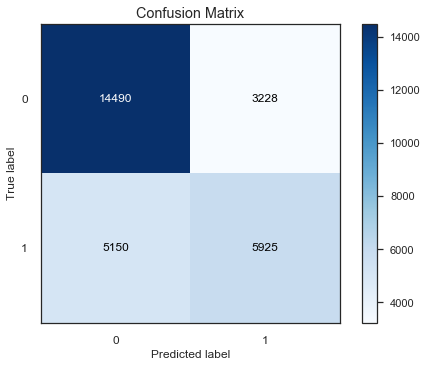

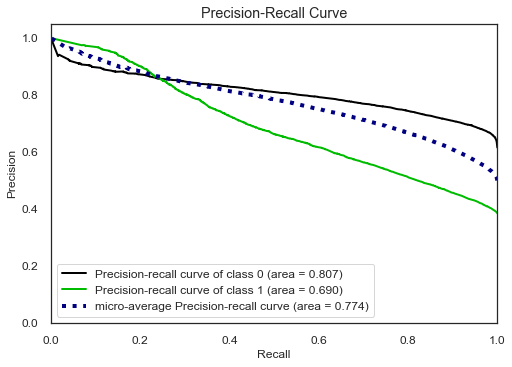

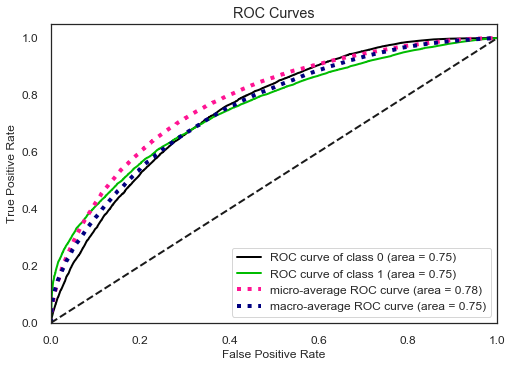

In [113]:
model_plot_rf(X_train_ss, y_train, X_test_ss, y_test)

Scaling the data does not seem to improve results, let's try resampling

## Modified Data modelling - Upsampling

In [114]:
# separate minority and majority classes
not_clicked = df_train[df_train.click_target==0]
clicked = df_train[df_train.click_target==1]

# up sample minority
clicked_upsampled = resample(clicked,
                          replace=True, # sample with replacement
                          n_samples=len(not_clicked), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_clicked, clicked_upsampled])
# check new class counts
upsampled.click_target.value_counts()

1    71114
0    71114
Name: click_target, dtype: int64

### Upsampling - Unscaled

In [115]:
# Separate input features and target
y_up = upsampled.click_target
X_up = upsampled.drop(['click_target'], axis=1)
# setting up testing and training sets
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    shuffle=True)

AUC: 0.724
Predicted customer clicks (test set): 14364
Sum of predicted click probabilities: 13890.52
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     17718
           1       0.54      0.70      0.61     11075

    accuracy                           0.66     28793
   macro avg       0.66      0.67      0.65     28793
weighted avg       0.68      0.66      0.66     28793



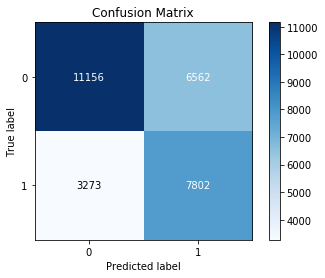

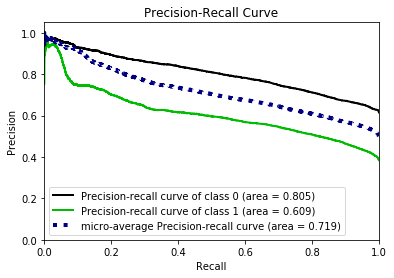

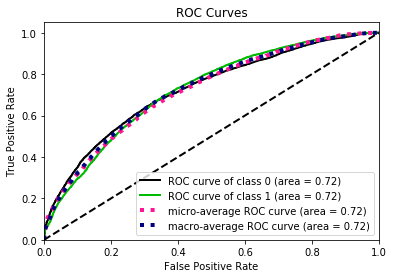

In [76]:
model_plot(X_train=X_train_up, y_train=y_train_up, X_test=X_test, y_test=y_test)

AUC: 0.942
Predicted customer clicks (test set): 11024
Sum of predicted click probabilities: 11803.71
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     17718
           1       0.84      0.84      0.84     11075

    accuracy                           0.88     28793
   macro avg       0.87      0.87      0.87     28793
weighted avg       0.88      0.88      0.88     28793



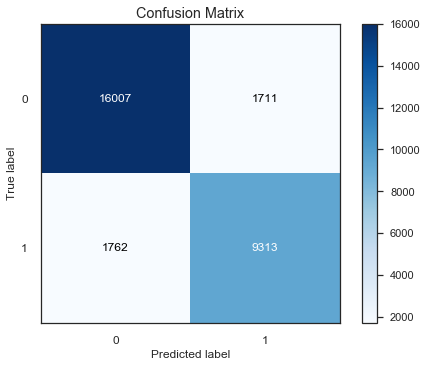

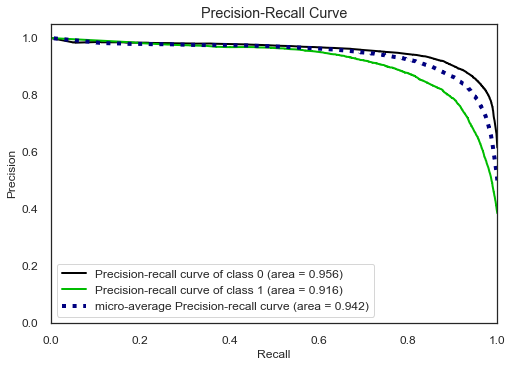

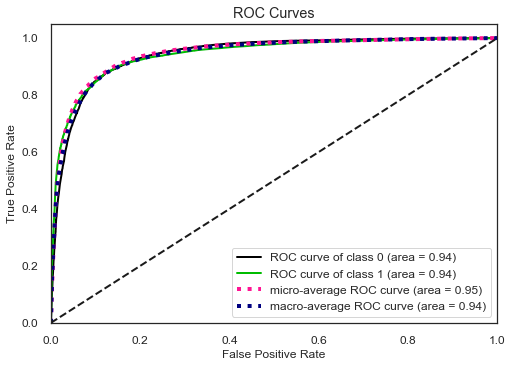

In [116]:
model_plot_rf(X_train=X_train_up, y_train=y_train_up, X_test=X_test, y_test=y_test)

### Upsampling - Scaled MM

In [117]:
# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_up_mm = scaler.fit_transform(X_train_up)
X_test_up_mm = scaler.fit_transform(X_test_up)

AUC: 0.724
Predicted customer clicks (test set): 14361
Sum of predicted click probabilities: 13893.24
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     17718
           1       0.54      0.70      0.61     11075

    accuracy                           0.66     28793
   macro avg       0.66      0.67      0.65     28793
weighted avg       0.68      0.66      0.66     28793



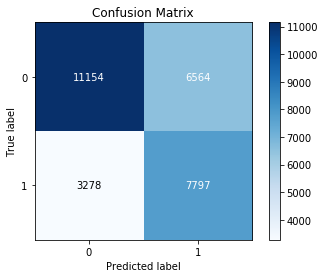

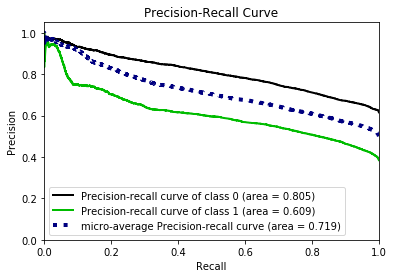

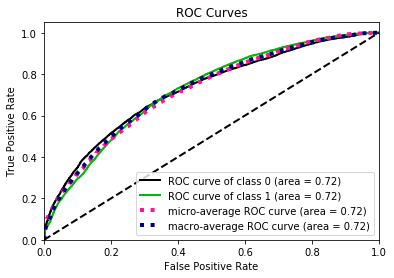

In [78]:
model_plot(X_train=X_train_up_mm, y_train=y_train_up, X_test=X_test_mm, y_test=y_test)

AUC: 0.942
Predicted customer clicks (test set): 11025
Sum of predicted click probabilities: 11801.38
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     17718
           1       0.84      0.84      0.84     11075

    accuracy                           0.88     28793
   macro avg       0.87      0.87      0.87     28793
weighted avg       0.88      0.88      0.88     28793



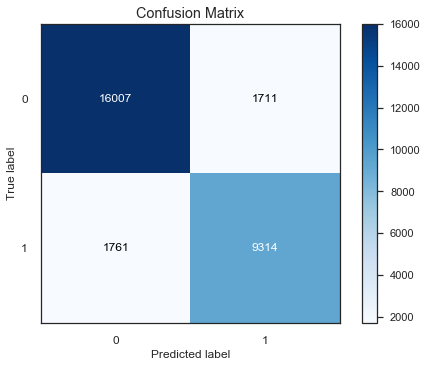

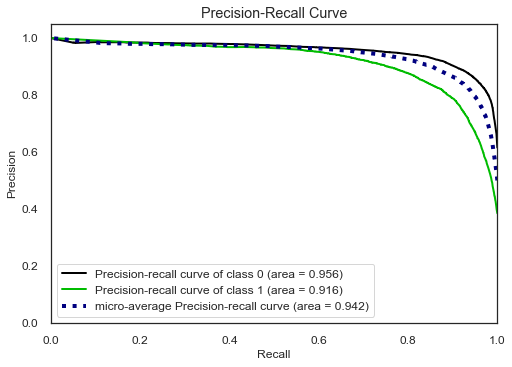

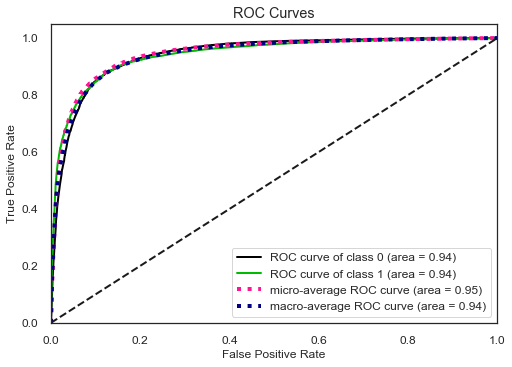

In [118]:
model_plot_rf(X_train=X_train_up_mm, y_train=y_train_up, X_test=X_test_mm, y_test=y_test)

### Upsampling - Scaled SS

In [119]:
# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = StandardScaler()
X_train_up_ss = scaler.fit_transform(X_train_up)
X_test_up_ss = scaler.fit_transform(X_test_up)

AUC: 0.724
Predicted customer clicks (test set): 15207
Sum of predicted click probabilities: 14350.97
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.78      0.60      0.68     17718
           1       0.53      0.73      0.62     11075

    accuracy                           0.65     28793
   macro avg       0.66      0.67      0.65     28793
weighted avg       0.69      0.65      0.65     28793



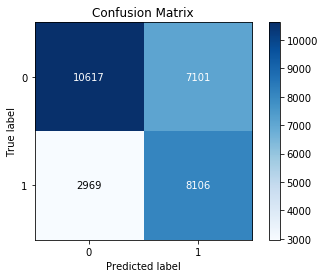

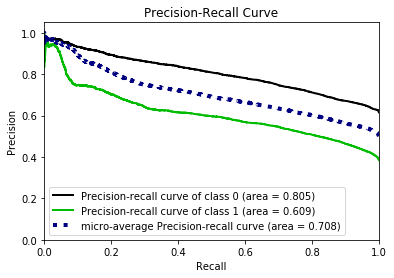

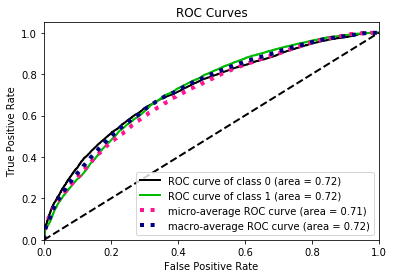

In [80]:
model_plot(X_train_up_ss, y_train_up, X_test_ss, y_test)

AUC: 0.901
Predicted customer clicks (test set): 11396
Sum of predicted click probabilities: 12844.70
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     17718
           1       0.77      0.80      0.78     11075

    accuracy                           0.83     28793
   macro avg       0.82      0.83      0.82     28793
weighted avg       0.83      0.83      0.83     28793



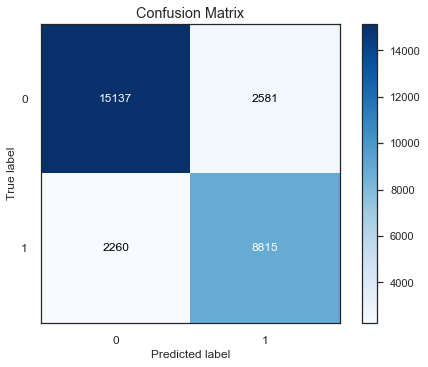

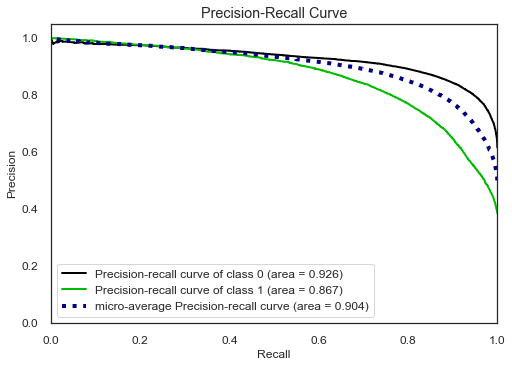

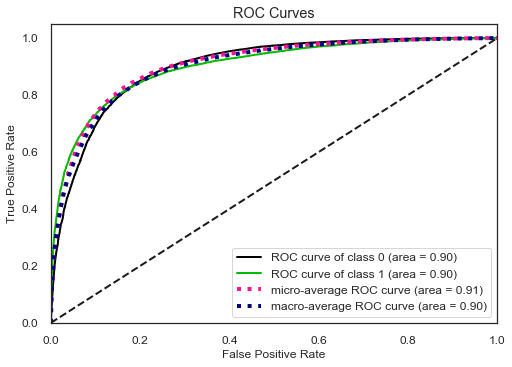

In [121]:
model_plot_rf(X_train_up_ss, y_train_up, X_test_ss, y_test)

Upsampling and then standard scaling imprves f1 slightly

## Modified Data Modelling - SMOTE

In [122]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_sm.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_sm==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_sm==0)))
get_class_dist(data=y_train_sm, name='y_train_sm')

Before OverSampling, counts of label '1': 32980
Before OverSampling, counts of label '0': 53396 

After OverSampling, the shape of train_X: (106792, 25)
After OverSampling, the shape of train_y: (106792,) 

After OverSampling, counts of label '1': 53396
After OverSampling, counts of label '0': 53396 

106792 total examples in y_train_sm
class 0: 53396 examples, 50.00%
class 1: 53396 examples, 50.00%



### SMOTE - Unscaled

AUC: 0.724
Predicted customer clicks (test set): 14231
Sum of predicted click probabilities: 13814.17
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.77      0.63      0.70     17718
           1       0.55      0.70      0.61     11075

    accuracy                           0.66     28793
   macro avg       0.66      0.67      0.66     28793
weighted avg       0.69      0.66      0.66     28793



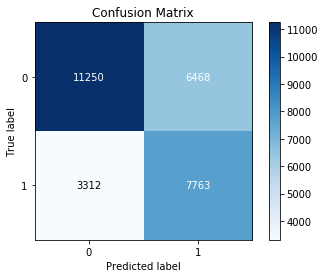

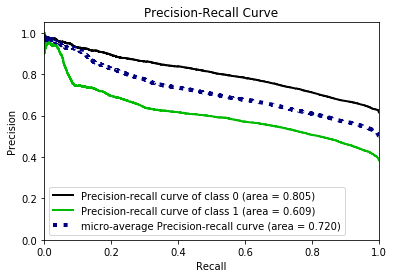

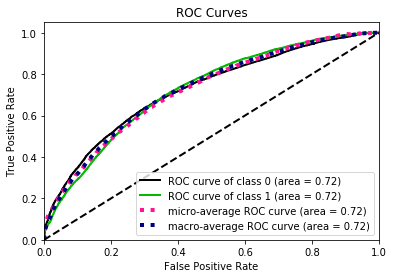

In [82]:
model_plot(X_train_sm, y_train_sm, X_test, y_test.values)

AUC: 0.743
Predicted customer clicks (test set): 9706
Sum of predicted click probabilities: 11507.16
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.74      0.80      0.77     17718
           1       0.63      0.55      0.59     11075

    accuracy                           0.70     28793
   macro avg       0.69      0.68      0.68     28793
weighted avg       0.70      0.70      0.70     28793



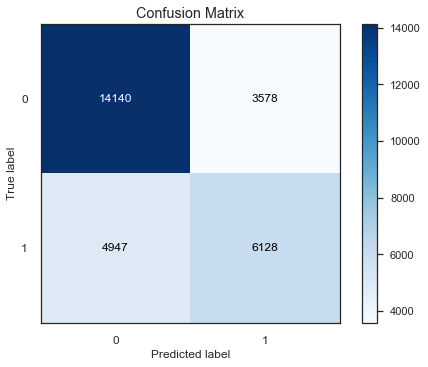

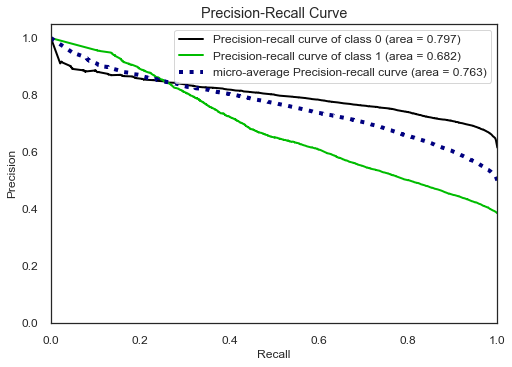

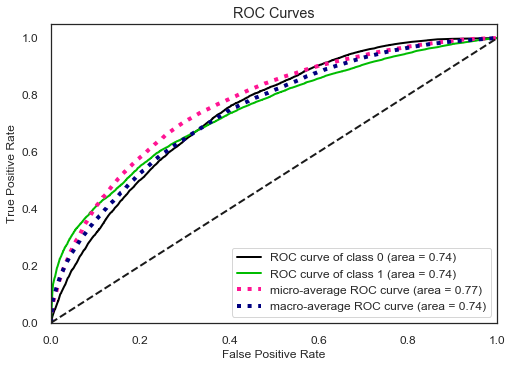

In [123]:
model_plot_rf(X_train_sm, y_train_sm, X_test, y_test.values)

### SMOTE - Scaled MM

In [124]:
# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_sm_mm = scaler.fit_transform(X_train_sm)

AUC: 0.724
Predicted customer clicks (test set): 14258
Sum of predicted click probabilities: 13815.07
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.77      0.63      0.70     17718
           1       0.54      0.70      0.61     11075

    accuracy                           0.66     28793
   macro avg       0.66      0.67      0.65     28793
weighted avg       0.68      0.66      0.66     28793



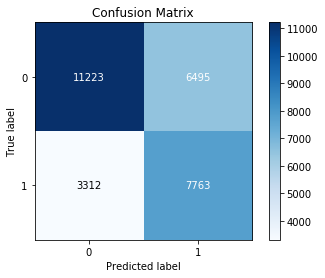

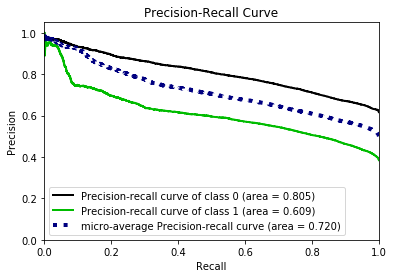

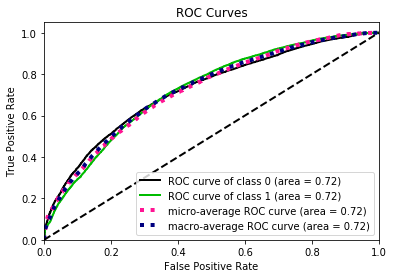

In [84]:
model_plot(X_train_sm_mm, y_train_sm, X_test_mm, y_test)

AUC: 0.743
Predicted customer clicks (test set): 9708
Sum of predicted click probabilities: 11494.57
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.74      0.80      0.77     17718
           1       0.63      0.55      0.59     11075

    accuracy                           0.70     28793
   macro avg       0.69      0.68      0.68     28793
weighted avg       0.70      0.70      0.70     28793



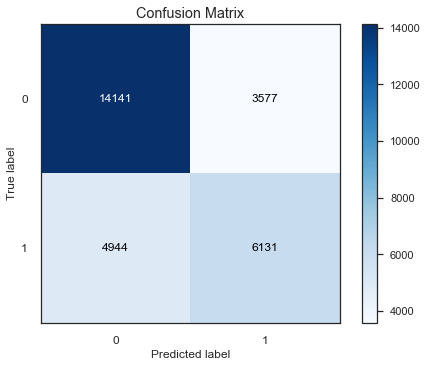

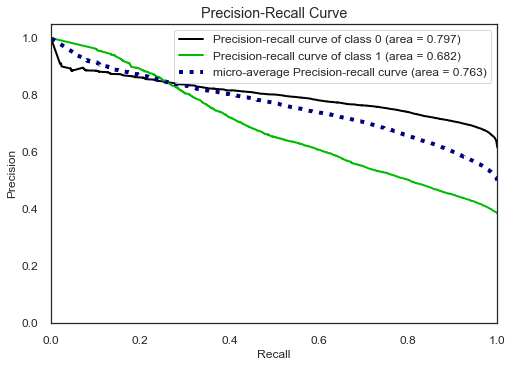

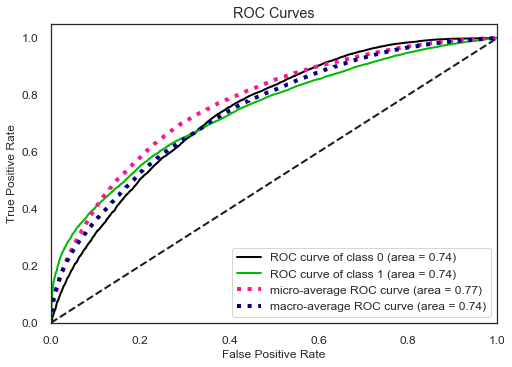

In [125]:
model_plot_rf(X_train_sm_mm, y_train_sm, X_test_mm, y_test)

### SMOTE - Scaled SS

In [126]:
# Scale X to have a mean of 0
scaler = StandardScaler()
X_train_sm_ss = scaler.fit_transform(X_train_sm)

AUC: 0.724
Predicted customer clicks (test set): 15187
Sum of predicted click probabilities: 14353.92
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.78      0.60      0.68     17718
           1       0.53      0.73      0.62     11075

    accuracy                           0.65     28793
   macro avg       0.66      0.67      0.65     28793
weighted avg       0.69      0.65      0.65     28793



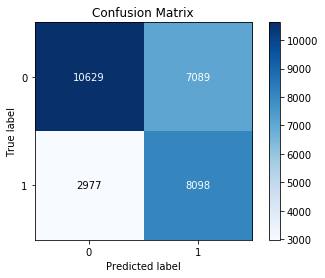

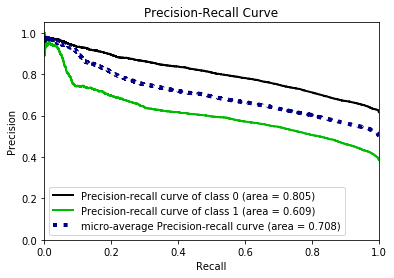

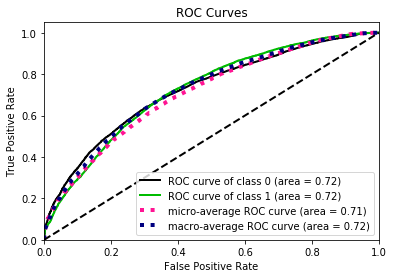

In [86]:
model_plot(X_train_sm_ss, y_train_sm, X_test_ss, y_test)

AUC: 0.601
Predicted customer clicks (test set): 28360
Sum of predicted click probabilities: 25131.27
Actual customer clicks (test set): 11075

              precision    recall  f1-score   support

           0       0.80      0.02      0.04     17718
           1       0.39      0.99      0.56     11075

    accuracy                           0.39     28793
   macro avg       0.60      0.51      0.30     28793
weighted avg       0.64      0.39      0.24     28793



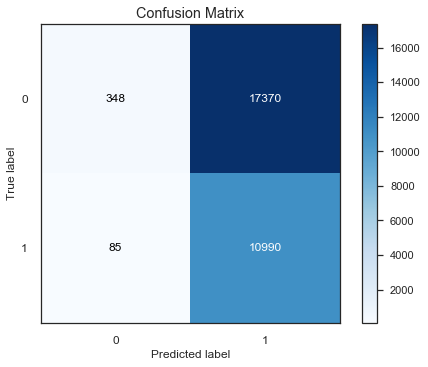

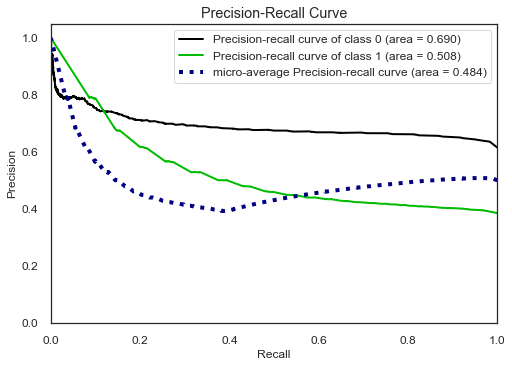

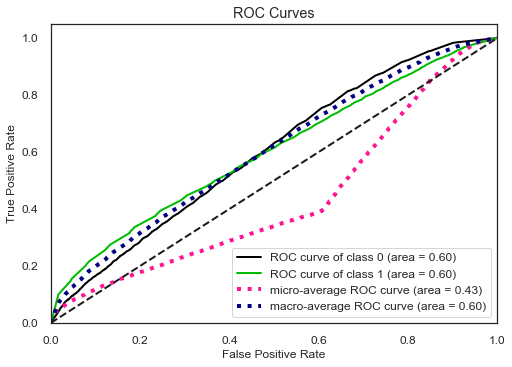

In [127]:
model_plot_rf(X_train_sm_ss, y_train_sm, X_test_ss, y_test)

# Feature Relevance

## PCA

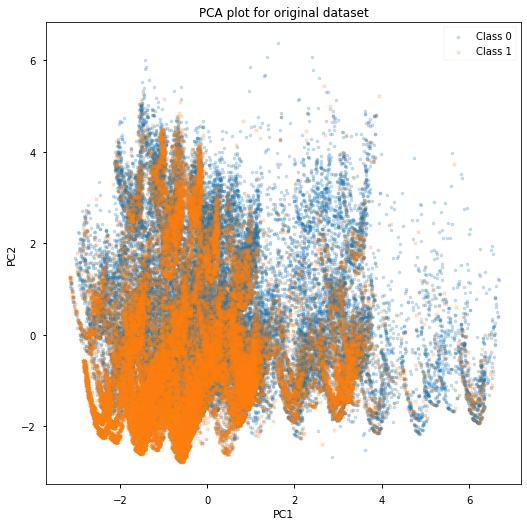

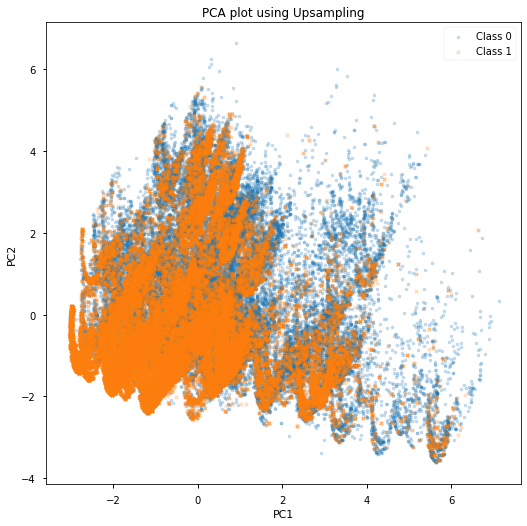

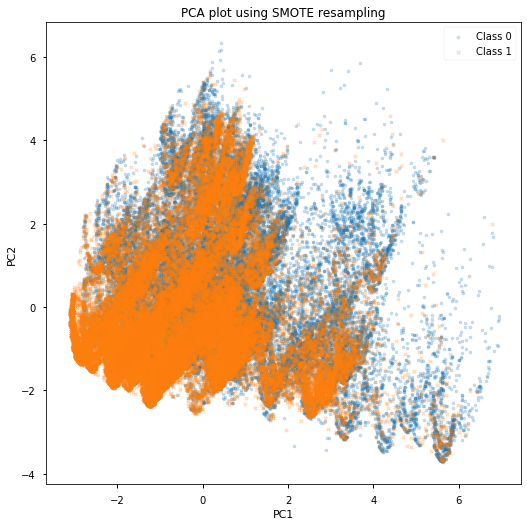

In [87]:
def pca_plot(X, y, title):
    """via https://github.com/wangz10/class_imbalance/blob/master/Main.ipynb"""
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 3)
    X_pc = pca.fit_transform(X)
     
    plt.style.use('seaborn-notebook')
    fig, ax = plt.subplots(figsize=(8.5, 8.5))
    mask = y==0
    ax.scatter(X_pc[mask, 1], X_pc[mask, 2], color='#1f77b4', marker='o', label='Class 0', alpha=0.25, s=10)
    ax.scatter(X_pc[~mask, 1], X_pc[~mask, 2], color='#ff7f0e', marker='x', label='Class 1', alpha=0.25, s=10)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='best')
    plt.title(title);
    return
 
pca_plot(X_train, y_train, title='PCA plot for original dataset')
pca_plot(X_train_up, y_train_up, title='PCA plot using Upsampling')
pca_plot(X_train_sm, y_train_sm, title='PCA plot using SMOTE resampling')

## Feature Selection

Creating some helper fucntions to run models and their accuracies

In [88]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def runModel(model, Xw, y, cv):
    if cv==False:
        model.fit(Xw,y)
        score = model.score(Xw,y)     
    else:
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        scores = cross_val_score(model, Xw, y, cv=kfold, scoring='roc_auc')
        score = np.array(scores).mean()
    return(score)

In [89]:
def RFAperf(ranking, modelstr, Xw, y, names, cv=False):
    ranking = list(ranking)
    model = eval(modelstr)
    l = len(ranking)
    
    f_inds = []
    f_names = np.array([])
    f_scorelist = []
    for i in range(1, l+1):
        f_ind = ranking.index(i)
        f_inds.append(f_ind)
        f_names = np.append(f_names, names[f_ind])
        Xin = Xw[:,f_inds]
        score = runModel(model, Xin, y, cv)
        f_scorelist.append((f_names, score))

    return(f_scorelist)

## Recursive Feature Elimination

Ranking function for RFE

In [90]:
def rankRFE(models, Xversions, y, names):
    lnames = len(names)
    FAstr = 'RFE'
    
    modelsData = []
    results = pd.DataFrame([], index=range(1,lnames+1))
    for inputType, Xw in Xversions:
        for model in models:
            modelname = str(model).partition("(")[0]
            rfe = RFE(model, 1)
            # rank RFE results
            rfe.fit(Xw, y)
            ranking = rfe.ranking_
            f_scorelist = RFAperf(ranking, str(model), Xw, y, names, cv=True)
            modelsData.append( (inputType, str(model), FAstr, ranking, f_scorelist) ) 
            f_ranking = [n for r, n in sorted( zip( ranking, names ) )]
            results[modelname[0:3] + FAstr + '-' + inputType[0:2]] = f_ranking
    
    return(modelsData, results)

Create a plotting function to help vizulaise the results of RFE

In [91]:
def plotRFAdata(modelsData, names):
    n = len(modelsData)
    l = len(names)
    
    fig = plt.figure()
    xvals = range(1,l+1)
    colorVec = ['ro', 'go', 'bo', 'co', 'mo', 'yo', 'ko', 'rs', 'gs', 'bs', 'cs', 'ms', 'ys', 'ks']
    for i in range(n):
        modelData = modelsData[i]
        inputType = modelData[0]
        modelstr = modelData[1]
        modelname = modelstr.partition('(')[0]
        FAstr = modelData[2]
        ranking = modelData[3]
        f_scorelist = modelData[4]
        f = np.array(f_scorelist)[:,0]
        s = np.array(f_scorelist)[:,1]
        labelstr = modelname[0:3] + FAstr + '-' + inputType[0:2]
        plt.plot(xvals, s, colorVec[i]+'-',  label=labelstr)
      
    fig.suptitle('Recursive Feature Augmentation Performance')
    plt.ylabel('roc_auc')
    #plt.ylim(ymax=1)
    plt.xlabel('Number of Features')
    plt.xlim(1-0.1,l+0.1)
    plt.legend(loc='lower right', fontsize=10)
    ax = fig.add_subplot(111)
    ax.set_xticks(xvals)
    plt.show()

In [92]:
clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=3000)

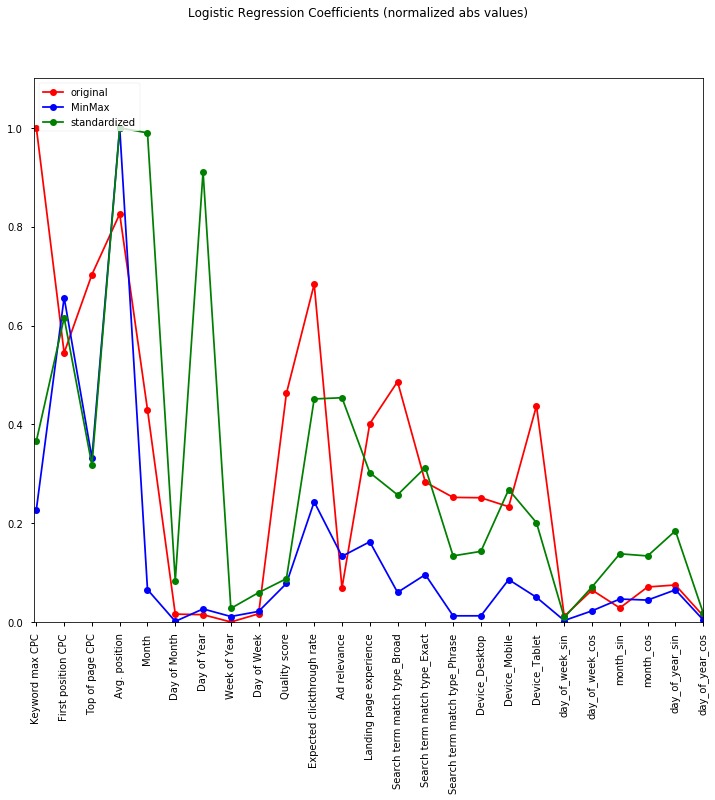

In [93]:
names = list(X_train.columns)
lnames = len(names)

# Regression coefficients for unscaled, scaled and standardized input
coef_or = abs(clf.fit(X_train,y_train).coef_[0])
coef_mm = abs(clf.fit(X_train_mm,y_train).coef_[0])
coef_ss = abs(clf.fit(X_train_ss,y_train).coef_[0])

#f_ranking = zip(*sorted(zip(abs(rfe.estimator_.coef_), names)))[1]
#f_ranking = [n for r, n in sorted( zip( abs(model.coef_), names ) , reverse=True)]

fig = plt.figure(figsize=(12,10))
fig.suptitle('Logistic Regression Coefficients (normalized abs values)')
ax = fig.add_subplot(111)
plt.plot(range(lnames), coef_or/max(coef_or), 'ro-', label='original')
plt.plot(range(lnames), coef_mm/max(coef_mm), 'bo-', label='MinMax')
plt.plot(range(lnames), coef_ss/max(coef_ss), 'go-', label='standardized')
plt.legend(loc='upper left', fontsize=10)
plt.xlim(-0.1, 6.1)
plt.ylim(0, 1.1)
plt.xticks(rotation='vertical')
ax.set_xticks(range(lnames))
ax.set_xticklabels(names, fontsize=10)
#ax.text(0.7, 1.4, 'Ranking: %s '%f_ranking)
plt.show()

`Keyword max CPC`, `First position CPC`, `Top of page CPC`, `Avg. position`, `Impressions` and as expected `Expected clickthrough rate` seem to be the most important features but looking at a list will be easier to analyse

take out impressions and qs

In [94]:
FAstr = 'Coeffs'
#rfe = RFE(model, 1)

# prepare test
scaling = [('original', X_train), ('MinMax', X_train_mm), ('standardized', X_train_ss)]

modelsData = []
lnames = len(names)
results = pd.DataFrame([], index=range(1,lnames+1))
for inputType, Xw in scaling:
    
    clf.fit(Xw, y_train)
    
    # extract ranking array from linear coefficients
    ranking = np.zeros((lnames,), dtype=np.int)
    f_r = [n for r, n in sorted(zip(abs(clf.coef_[0]), range(lnames)) , reverse=True)]
    ranking[f_r] = range(1,lnames+1)

    # store all results to modelsData
    modelsData.append((inputType, str(clf), FAstr, ranking)) 
    
    # augment results for table display
    f_ranking = [n for r, n in sorted(zip(abs(clf.coef_[0]), names) , reverse=True)]
    results[FAstr + '-' + inputType[0:2]] = f_ranking
    
resultsCoeffs = results
from IPython.display import display
display(resultsCoeffs)

,Coeffs-or,Coeffs-Mi,Coeffs-st
1,Keyword max CPC,Avg. position,Avg. position
2,Avg. position,First position CPC,Month
3,Top of page CPC,Top of page CPC,Day of Year
4,Expected clickthrough rate,Expected clickthrough rate,First position CPC
5,First position CPC,Keyword max CPC,Ad relevance
6,Search term match type_Broad,Landing page experience,Expected clickthrough rate
7,Quality score,Ad relevance,Keyword max CPC
8,Device_Tablet,Search term match type_Exact,Top of page CPC
9,Month,Device_Mobile,Search term match type_Exact
10,Landing page experience,Quality score,Landing page experience


# Cross Validation and Model Comparison

In [95]:
# Define a function to plot barplot comparisons of models
def barplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')

    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)
    
    # Plot bars
    sns.barplot(x=x, y=y1, data=df, palette='muted', ax=axs[0])
    sns.barplot(x=x, y=y2, data=df, palette='muted', ax=axs[1])

    # Tweak the visual presentation
    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    sns.despine(trim=True, left=True);
    
    return

# Define a function to plot boxplot comparisons of models
def boxplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')

    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)

    # Plot boxes
    sns.boxplot(x=x, y=y1, data=df,
                whis='range', palette='muted', ax=axs[0])
    sns.boxplot(x=x, y=y2, data=df,
                whis='range', palette='muted', ax=axs[1])

    # Add in points to show each observation
    sns.swarmplot(x=x, y=y1, data=df,
                  size=4, color='.3', linewidth=0, ax=axs[0])
    sns.swarmplot(x=x, y=y2, data=df,
                  size=4, color='.3', linewidth=0, ax=axs[1])

    # Tweak the visual presentation
    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    #axs[1].set_ylim(axs[1].get_ylim()[::-1])
    sns.despine(trim=True, left=True);
    
    return

# Define a function to run stratified k-fold cross-validation and return scores for different models
# If resampling is set, the model will resample within each fold of the cross-validation
def check_model(model, resampling, calibrate, X=X, y=y, k=5, print_res=True, plot_pca=False, random_state=42):
    
    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Define the cross-validation parameters
    # Common values of k are 5 and 10, as these have been shown experimentally to produce the best results
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Create lists to save results to
    mcc = []
    brier = []
    actual_clicks = []
    pred_clicks = []
    model_name = model.__class__.__name__

    # Create training and test data using cross validation and fit model for each fold
    for ii, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if resampling == None:
            res = 'no'
        else:
            X_train, y_train = resampling.fit_resample(X_train, y_train)
            res = resampling.__class__.__name__

        # Calibrate model if necessary
        if calibrate == None:
            calibrated_probs = 'uncalibrated probabilities'
            model.fit(X_train, y_train)
        else:
            model = CalibratedClassifierCV(model, cv=2, method=calibrate)
            model.fit(X_train, y_train)
            calibrated_probs = '%s calibration' % calibrate    
            
        y_pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)[:,1]
        
        # Calculate mcc score, brier_loss and sum of predicted goal probabilities
        actual_clicks.append(sum(y_valid))
        pred_clicks.append(sum(y_pred_proba))
        mcc.append(matthews_corrcoef(y_valid, y_pred))
        brier.append(brier_score_loss(y_valid, y_pred_proba))
        
        if plot_pca == True and ii == 0:
            pca_plot(X_train, y_train, title='%s with %s resampling (1st fold)'
              % (model_name, res))
        else: pass
    
    # Save the results to a dataframe
    df = pd.DataFrame()
    df['model'] = model_name
    df['resampling'] = res
    df['mcc'] = mcc
    df['brier_loss'] = brier
    df['actual_clicks'] = actual_clicks
    df['predicted_clicks'] = pred_clicks
    df['clicks_diff'] = abs(df['actual_clicks'] - df['predicted_clicks'])
    df['calibrated'] = calibrated_probs
    
    # Print a summary of the results if required
    if print_res == True:
        print('Method: %s with %s resampling and %s'
              % (model_name, res, calibrated_probs))
        print('Clicks:', '{0:.2f}'.format(df['actual_clicks'].mean()))
        print('Predicted Clicks:', '{0:.2f}'.format(df['predicted_clicks'].mean()))
        print('MCC:', '{0:.3f}'.format(df['mcc'].mean()))
        print('Brier Loss:', '{0:.3f}'.format(df['brier_loss'].mean()))
        print('')
    else: pass

    return df

## Resampling Methods with Cross Validation

Method: LogisticRegression with no resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 8316.18
MCC: 0.320
Brier Loss: 0.213

Method: LogisticRegression with SMOTE resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 9949.97
MCC: 0.301
Brier Loss: 0.243

Method: LogisticRegression with TomekLinks resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 8824.31
MCC: 0.316
Brier Loss: 0.221

Method: LogisticRegression with EditedNearestNeighbours resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 12240.17
MCC: 0.259
Brier Loss: 0.321

Method: LogisticRegression with SMOTETomek resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 9496.74
MCC: 0.304
Brier Loss: 0.234

Method: LogisticRegression with SMOTEENN resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 6521.72
MCC: 0.310
Brier Loss: 0.208



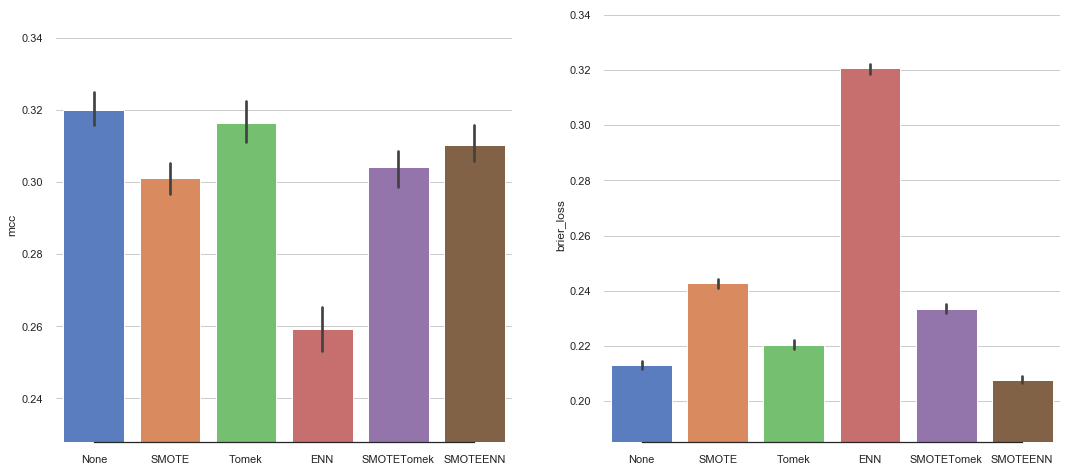

In [96]:
# Try different re-sampling methods with a lr
# For some reason sklearn and imblearn's default is to use only one processor core
# Most people have multiple cores these days!
# n_jobs=-1 will run the model on all cores in parallel, which can speed things up quite a bit

tomek = TomekLinks(n_jobs=-1, random_state=42)
enn = EditedNearestNeighbours(n_jobs=-1, random_state=42)
smote_tomek = SMOTETomek(tomek=tomek, random_state=42)
smote_enn = SMOTEENN(enn=enn, random_state=42)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
lr = LogisticRegression(class_weight=class_weights_dict, random_state=42, solver='lbfgs', max_iter=3000)


models = []
# Format is name, model, resampling method, probability calibration
models.append(('None', lr, None, None))
models.append(('SMOTE', lr, smote, None))
models.append(('Tomek', lr, tomek, None))
models.append(('ENN', lr, enn, None))
models.append(('SMOTETomek', lr, smote_tomek, None))
models.append(('SMOTEENN', lr, smote_enn, None))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate, X=X_train, y=y_train)
    result['name'] = name
    results_df = results_df.append(result)

# Call boxplot_comparison here instead if you like
barplot_comparison(results_df)

Method: RandomForestClassifier with no resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 6731.96
MCC: 0.361
Brier Loss: 0.201

Method: RandomForestClassifier with SMOTE resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 6937.70
MCC: 0.362
Brier Loss: 0.202

Method: RandomForestClassifier with TomekLinks resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 7314.78
MCC: 0.361
Brier Loss: 0.203

Method: RandomForestClassifier with EditedNearestNeighbours resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 11066.90
MCC: 0.316
Brier Loss: 0.281

Method: RandomForestClassifier with SMOTETomek resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 6327.16
MCC: 0.370
Brier Loss: 0.201

Method: RandomForestClassifier with SMOTEENN resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 3882.78
MCC: 0.355
Brier Loss: 0.224



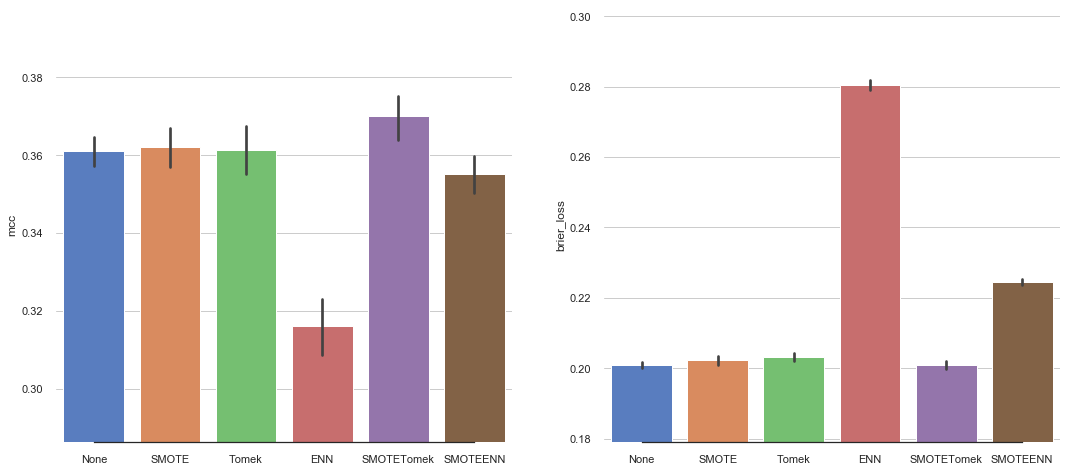

In [97]:
# Try different re-sampling methods with a lr
# For some reason sklearn and imblearn's default is to use only one processor core
# Most people have multiple cores these days!
# n_jobs=-1 will run the model on all cores in parallel, which can speed things up quite a bit

tomek = TomekLinks(n_jobs=-1, random_state=42)
enn = EditedNearestNeighbours(n_jobs=-1, random_state=42)
smote_tomek = SMOTETomek(tomek=tomek, random_state=42)
smote_enn = SMOTEENN(enn=enn, random_state=42)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
lr = LogisticRegression(class_weight=class_weights_dict, random_state=42, solver='lbfgs', max_iter=3000)


models = []
# Format is name, model, resampling method, probability calibration
models.append(('None', rf, None, None))
models.append(('SMOTE', rf, smote, None))
models.append(('Tomek', rf, tomek, None))
models.append(('ENN', rf, enn, None))
models.append(('SMOTETomek', rf, smote_tomek, None))
models.append(('SMOTEENN', rf, smote_enn, None))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate, X=X_train, y=y_train)
    result['name'] = name
    results_df = results_df.append(result)

# Call boxplot_comparison here instead if you like
barplot_comparison(results_df)

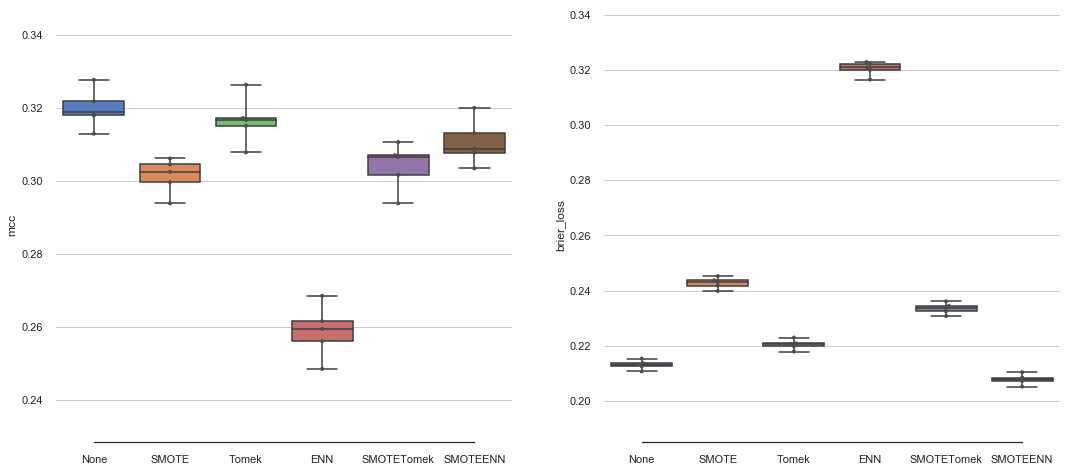

In [130]:
boxplot_comparison(results_df)

### With Sigmoid Caliberation

Method: LogisticRegression with no resampling and sigmoid calibration
Clicks: 6596.00
Predicted Clicks: 6595.32
MCC: 0.289
Brier Loss: 0.204

Method: LogisticRegression with SMOTE resampling and sigmoid calibration
Clicks: 6596.00
Predicted Clicks: 8262.99
MCC: 0.321
Brier Loss: 0.213

Method: LogisticRegression with TomekLinks resampling and sigmoid calibration
Clicks: 6596.00
Predicted Clicks: 7099.66
MCC: 0.308
Brier Loss: 0.204

Method: LogisticRegression with EditedNearestNeighbours resampling and sigmoid calibration
Clicks: 6596.00
Predicted Clicks: 10993.23
MCC: 0.290
Brier Loss: 0.283

Method: LogisticRegression with SMOTETomek resampling and sigmoid calibration
Clicks: 6596.00
Predicted Clicks: 7834.99
MCC: 0.320
Brier Loss: 0.209

Method: LogisticRegression with SMOTEENN resampling and sigmoid calibration
Clicks: 6596.00
Predicted Clicks: 5131.61
MCC: 0.267
Brier Loss: 0.217



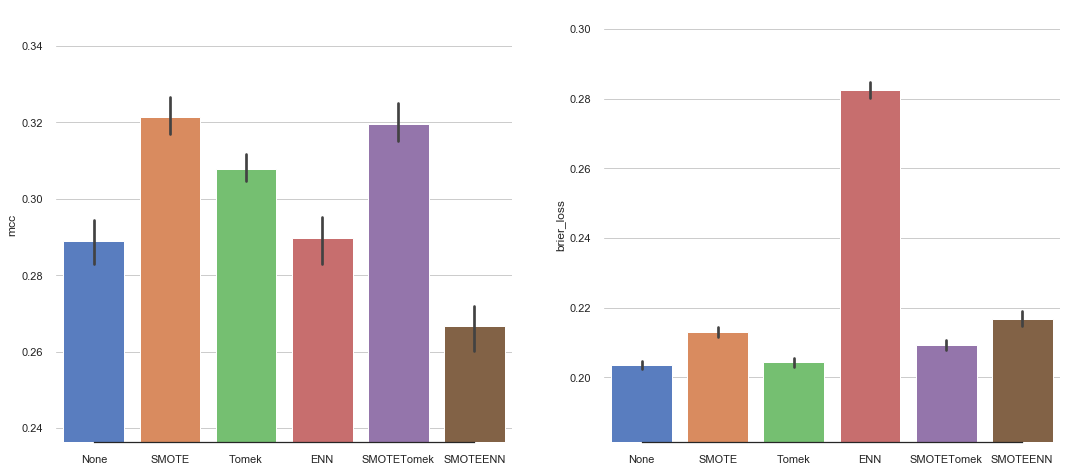

In [133]:
# Try different re-sampling methods with a LogReg classfier
# For some reason sklearn and imblearn's default is to use only one processor core
# Most people have multiple cores these days!
# n_jobs=-1 will run the model on all cores in parallel, which can speed things up quite a bit

tomek = TomekLinks(n_jobs=-1, random_state=42)
enn = EditedNearestNeighbours(n_jobs=-1, random_state=42)
smote_tomek = SMOTETomek(tomek=tomek, random_state=42)
smote_enn = SMOTEENN(enn=enn, random_state=42)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
lr = LogisticRegression(class_weight=class_weights_dict, random_state=42, solver='lbfgs', max_iter=3000)


models = []
# Format is name, model, resampling method, probability calibration
models.append(('None', lr, None, 'sigmoid'))
models.append(('SMOTE', lr, smote, 'sigmoid'))
models.append(('Tomek', lr, tomek, 'sigmoid'))
models.append(('ENN', lr, enn, 'sigmoid'))
models.append(('SMOTETomek', lr, smote_tomek, 'sigmoid'))
models.append(('SMOTEENN', lr, smote_enn, 'sigmoid'))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate, X=X_train, y=y_train)
    result['name'] = name
    results_df = results_df.append(result)

# Call boxplot_comparison here instead if you like
barplot_comparison(results_df)

Method: RandomForestClassifier with no resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 6731.96
MCC: 0.361
Brier Loss: 0.201

Method: BalancedRandomForestClassifier with no resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 8161.65
MCC: 0.390
Brier Loss: 0.192

Method: AdaBoostClassifier with no resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 8611.64
MCC: 0.380
Brier Loss: 0.248

Method: EasyEnsembleClassifier with no resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 8627.77
MCC: 0.384
Brier Loss: 0.247

Method: XGBClassifier with no resampling and uncalibrated probabilities
Clicks: 6596.00
Predicted Clicks: 6595.54
MCC: 0.401
Brier Loss: 0.179



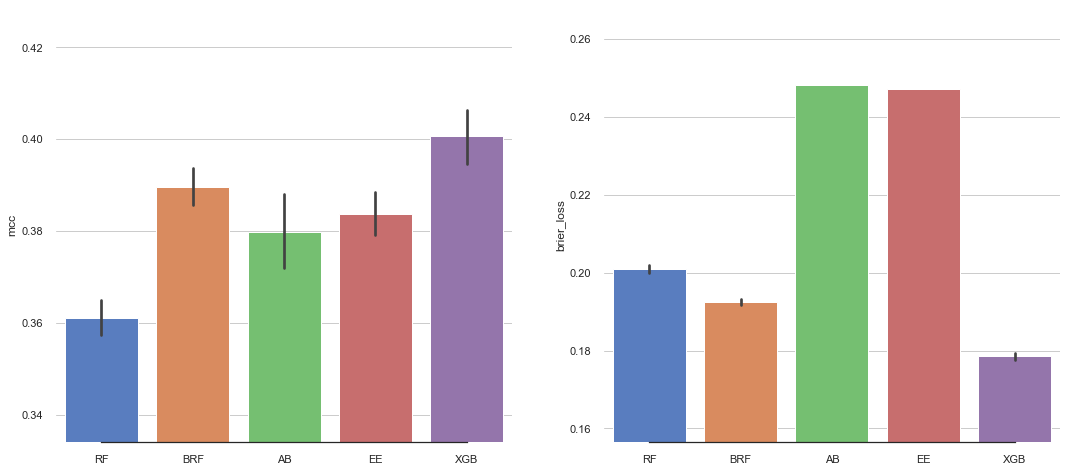

In [134]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
ab = AdaBoostClassifier(n_estimators=100, random_state=42)
ee = EasyEnsembleClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb = XGBClassifier(random_state=42)
 
models = []
models.append(('RF', rf, None, None))
models.append(('BRF', brf, None, None))
models.append(('AB', ab, None, None))
models.append(('EE', ee, None, None)) # takes forever to run with calibration!
models.append(('XGB', xgb, None, None))
 
results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate, X=X_train, y=y_train)
    result['name'] = name
    results_df = results_df.append(result)
     
barplot_comparison(results_df)

# RandomSearchCV

In [174]:
import pprint

In [176]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 85.6min


In [ ]:
rf_random.best_params_

Evaluating the random search for random forest classifier

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)
# Model Performance
# Average Error: 3.9199 degrees.
# Accuracy = 93.36%.
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)
# Model Performance
# Average Error: 3.7152 degrees.
# Accuracy = 93.73%.
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
# Improvement of 0.40%.

# GridSearchCV

## Logistic Regression 

In [131]:
from sklearn.model_selection import GridSearchCV
import time

In [167]:
max_iter = [1000, 2000, 3000, 4000]
C = [1.0,1.5,2.0,2.5]
class_weight_list = [class_weights_dict, 'balanced', None]
solver = ['liblinear', 'lbfgs', 'sag']
param_grid = dict(max_iter=max_iter, class_weight=class_weight_list, solver=solver)

In [169]:
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 5, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.678024 using {'class_weight': None, 'max_iter': 1000, 'solver': 'sag'}
Execution time: 557.7819547653198 ms


## RF

In [171]:
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [172]:
rf = RandomForestClassifier()
grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 5, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.728501 using {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}
Execution time: 2095.9599809646606 ms


# Checking for Overfitting

In [193]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_praba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_praba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        label_col_name - name of y-label. Change to whatever your model has it named. Default 'label'.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='+ (train)')

    train_neg = plt.hist(decisions[1],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='- (train)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='+ (test)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='- (test)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value) :'+str(round(ks[0],2))+'('+str(round(ks[1],2))+')')
    plt.legend(loc='best', fontsize=12)
    plt.show()
    plt.close()

In [ ]:
train_proba = clf.predict(X_train)
test_proba = clf.predict(X_test)

make_ks_plot(y_train, train_proba, y_test, test_proba)